# Section 2.2.2: Exponential Time-to-Event Prediction Model Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement the exponential time-to-event prediction model (Examples 2.2.1 and 2.2.2 in Section 2.2.2 of the monograph) as a PyTorch model. We specifically apply this model to the SUPPORT dataset (Knaus et al., 1995), which looks at the time until death (in days) of severely ill hospitalized patients with various diseases (where we treat the "time origin"---where we measure time until death from---to be when a patient first enters the study). We compute all the evaluation metrics of Section 2.4 that we discussed in detail.

### Loading in the SUPPORT dataset

We have written code already that loads in the SUPPORT dataset (using the same 14 features and the same number of patients as the DeepSurv paper (Katzman et al., 2018)) and splits it into training, validation, and test sets. We do this splitting in two steps:

1. We first get a 70%/30% split of the data from a helper function we have written (the `load_dataset` function in `datasets.py`). The 70% part we refer to as the "full training set", whereas the 30% part is the test set.
2. We then do a random 80%/20% split the full training set into the actual training set and a validation set.

Thus, overall what we have done is taken the full dataset and split it into 56%/14%/30% training/validation/test sets.

As we shall see shortly, the main neural network training procedure (minibatch gradient descent) uses the training set. The validation set is meant to simulate the true test set that we do not look at whatsoever during training. We use the validation set for tuning hyperparameters. For the simple exponential time-to-event prediction model, there are actually no hyperparameters of the model itself, but we could still tune on optimizer settings for minibatch gradient descent, such as the number of epochs, the batch size, the learning rate, or whether to stop training early (e.g., if there is no validation set loss error improvement after 10 training epochs, then stop training and return the model parameters to whatever their values were that achieved the best validation set loss). Later in this demo, as an illustrative example, we use the validation set to tune on the number of epochs used for training.

Note that at times in the code, we add the suffix `_np` to a Python variable to indicate that it is a NumPy array, and `_df` to indicate that it is a Pandas DataFrame. For PyTorch tensors, we typically do not add a suffix. This is because often the most involved parts of our demo code are in PyTorch, and in these parts, we try to avoid having the variable names get unwieldy.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor that we have written (see `datasets.py` for details on preprocessing) to get a "standardized" or "normalized" version of the training set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
print('Number of features before preprocessing:', X_train_raw_np.shape[1])
print('Number of features after preprocessing:', X_train_np.shape[1])

Number of features before preprocessing: 14
Number of features after preprocessing: 19


Much like how we wouldn't learn the preprocessor function so that it peeks at the true test set, we don't learn the preprocessor function so that it peeks at the validation set either. For this reason, notice that earlier we constructed the `preprocessor` object only using the training set and *not* also the validation set. We can apply the already learned `preprocessor` object (fitted to the training set) now to the validation set.

In [3]:
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Quick display of what the tabular data look like before and after preprocessing

Here's what the raw features look like:

In [4]:
import pandas as pd
X_train_raw_df = pd.DataFrame(X_train_raw_np, columns=features_before_preprocessing)
X_train_raw_df.head()

,age,female,race,num.co,diabetes,dementia,ca,meanbp,hrt,resp,temp,wblc,sod,crea
0,22.726990,1.0,2.0,0.0,0.0,0.0,0.0,99.0,112.0,40.0,38.500000,6.799805,134.0,0.799927
1,59.460999,1.0,5.0,1.0,0.0,0.0,2.0,52.0,175.0,26.0,38.898441,11.298828,131.0,1.000000
2,77.105957,0.0,5.0,1.0,0.0,0.0,1.0,103.0,112.0,9.0,37.593750,10.798828,143.0,0.799927
3,46.702000,0.0,5.0,1.0,0.0,0.0,0.0,71.0,71.0,24.0,36.398441,6.000000,141.0,0.799927
4,64.344971,1.0,5.0,5.0,0.0,0.0,2.0,65.0,114.0,12.0,36.500000,10.199219,138.0,1.599854


Here's what the features look like after preprocessing:

In [5]:
X_train_df = pd.DataFrame(X_train_np, columns=features_after_preprocessing)
X_train_df.head()

,age_std,female,num.co_norm,diabetes,dementia,ca_norm,meanbp_std,hrt_std,resp_std,temp_std,wblc_std,sod_std,crea_std,race_blank,race_asian,race_black,race_hispanic,race_other,race_white
0,-2.549160,1.0,0.000000,0.0,0.0,0.0,0.522356,0.455188,1.725720,1.115397,-0.602325,-0.578792,-0.574456,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.195510,1.0,0.111111,0.0,0.0,1.0,-1.185509,2.458527,0.260776,1.433982,-0.122097,-1.076014,-0.456761,0.0,0.0,0.0,0.0,0.0,1.0
2,0.935052,0.0,0.111111,0.0,0.0,0.5,0.667706,0.455188,-1.518085,0.390778,-0.175467,0.912876,-0.574456,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.013014,0.0,0.111111,0.0,0.0,0.0,-0.495095,-0.848572,0.051498,-0.564965,-0.687697,0.581394,-0.574456,0.0,0.0,0.0,0.0,0.0,1.0
4,0.117420,1.0,0.555556,0.0,0.0,1.0,-0.713121,0.518786,-1.204169,-0.483761,-0.239470,0.084172,-0.103891,0.0,0.0,0.0,0.0,0.0,1.0


### Preparing training and validation sets for use with PyTorch

Note that we use a CUDA GPU if it is available.

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up an exponential time-to-event prediction model

In the monograph, specifically for equation (2.6), we set

$$\mathbf{h}(t|x;\theta) := e^{\beta^\top x + \psi}.$$

How we implement this in code is that we actually model the *log* of $\mathbf{h}(t|x;\theta)$:

$$\log \mathbf{h}(t|x;\theta) = \beta^\top x + \psi.$$

As this just corresponds to a linear model, we can use PyTorch's `nn.Linear`, where the number of input features corresponds to the number of dimensions in $x$, the number of output features is 1, and--by default--`nn.Linear` includes a bias term (which will correspond to the $\psi$ variable above). Note that the linear model's weights correspond to what we called $\beta$.

In [7]:
import torch.nn as nn

torch.manual_seed(0)

num_input_features = X_train.size(1)

# simple neural net model that just does an inner product + a bias
# (note that constructing an nn.Linear object also does random
# parameter initialization)
log_hazards_model = nn.Linear(num_input_features, 1).to(device)

Right now the parameters have been randomly initialized as follows:

In [8]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[-0.0017,  0.1231, -0.1888, -0.1688, -0.0884,  0.0615, -0.0045,  0.1819,
         -0.0204,  0.0607, -0.0693, -0.0451, -0.2192, -0.1519, -0.0946,  0.0085,
          0.0907,  0.1377, -0.1555]], device='cuda:0', requires_grad=True)

In [9]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([-0.0999], device='cuda:0', requires_grad=True)

### Specifying the training loss function

In [10]:
def exp_nll_loss(predicted_log_hazards, Y_true, D_true):
    # the three inputs should all be 1D PyTorch tensors with the same number of entries

    # the loss is precisely L_{Hazard-NLL} given in Example 2.2.2 of the monograph
    return -(D_true * predicted_log_hazards - Y_true * (predicted_log_hazards.exp())).mean()

### Training the model using minibatch gradient descent

As an illustrative example, in this code, we use the validation set to decide on whether to use a previous epoch's learned model parameters. This could be viewed as a form of hyperparameter tuning where we are effectively selecting how many epochs to train the model for based on whichever achieves the best validation set loss.

In [11]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(log_hazards_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    log_hazards_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        log_hazards_batch = log_hazards_model(X_batch).view(-1)
        loss_batch = exp_nll_loss(log_hazards_batch, Y_batch, D_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    log_hazards_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            train_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            val_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(log_hazards_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
log_hazards_model.load_state_dict(best_params)

Epoch 1 - train loss 8.074995994567871 - val loss 8.270499229431152
Epoch 2 - train loss 6.748238563537598 - val loss 6.854441165924072
Epoch 3 - train loss 6.300990104675293 - val loss 6.365610122680664
Epoch 4 - train loss 6.040884971618652 - val loss 6.086954116821289
Epoch 5 - train loss 5.875169277191162 - val loss 5.907680988311768
Epoch 6 - train loss 5.7593255043029785 - val loss 5.784478187561035
Epoch 7 - train loss 5.673421859741211 - val loss 5.696872234344482
Epoch 8 - train loss 5.604191303253174 - val loss 5.623073577880859
Epoch 9 - train loss 5.544813632965088 - val loss 5.562973976135254
Epoch 10 - train loss 5.491061210632324 - val loss 5.5066986083984375
Epoch 11 - train loss 5.442178726196289 - val loss 5.456383228302002
Epoch 12 - train loss 5.396799564361572 - val loss 5.4111409187316895
Epoch 13 - train loss 5.354944229125977 - val loss 5.370354175567627
Epoch 14 - train loss 5.31557035446167 - val loss 5.331908226013184
Epoch 15 - train loss 5.281093120574951 -

<All keys matched successfully>

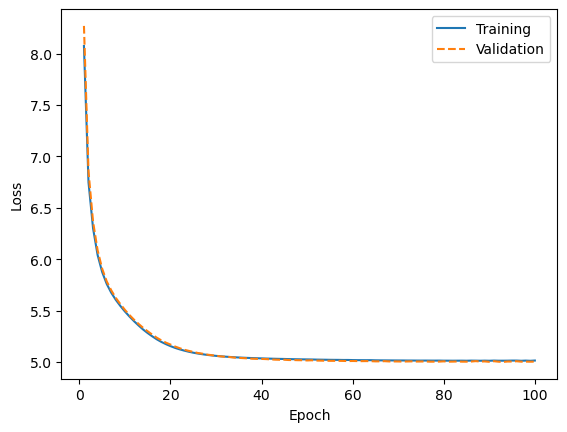

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the model, the model parameters are as follows:

In [13]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[ 0.2851, -0.1580,  0.0786,  0.0160,  0.6156,  1.2009, -0.0991,  0.1658,
         -0.0120, -0.0124,  0.0415, -0.0505,  0.0799, -2.8905, -3.3175, -3.2151,
         -3.3408, -3.3896, -3.4003]], device='cuda:0', requires_grad=True)

In [14]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([-3.4692], device='cuda:0', requires_grad=True)

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [15]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor)

Next, we apply the neural net model to the test data. We convert the resulting log hazard values to NumPy arrays since the plotting and evaluation code later on does not need nor use PyTorch.

In [16]:
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
with torch.no_grad():
    log_hazards_test = log_hazards_model(X_test)
    log_hazards_test_np = log_hazards_test.cpu().numpy()
print(log_hazards_test_np.shape)

(2662, 1)


To back out a survival curve, for simplicity we just use a time grid specified by the unique times in the test data (this is not the only way to specify a time grid; for examples of other ways, see Section 2.3.2 of the monograph).

In [17]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)
surv_test_np = np.exp(-time_grid_test_np*np.exp(log_hazards_test_np))  # equation (2.8) of the monograph applied to every test point
print(surv_test_np.shape)

(2662, 1061)


Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

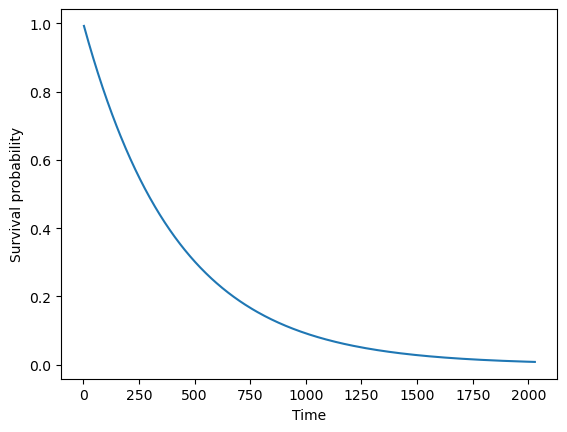

In [18]:
plt.plot(time_grid_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Concordance index (Harrell et al., 1982) using the scikit-survival implementation (Pölsterl, 2020)

In [19]:
from sksurv.metrics import concordance_index_censored

C_index = concordance_index_censored(D_test_np.astype(bool), Y_test_np, log_hazards_test_np.flatten())[0]
print(f"Harrell's concordance index: {C_index}")

Harrell's concordance index: 0.6015103136584986


#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

We had mentioned in the monograph that time-dependent concordance index (Antolini et al., 2005) becomes the same as Harrell's concordance index when the proportional hazards assumption holds, but we had mentioned this in the context where we do not treat ties (in predicted log hazards) in a special manner (i.e., we just apply Definitions 2.4.1 and 2.4.2 of the monograph). When there are ties, the code here handles ties a bit differently which is why it is possible for Harrell's concordance index to be close to but not identical to Antolini et al.'s time-dependent concordance index.

In [20]:
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6015091745851251


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

The training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [21]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5953761399115698
Eval time 693.0 - truncated time-dependent concordance: 0.6016806042300841
Eval time 1291.0 - truncated time-dependent concordance: 0.6030430535603264


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [22]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6615151728908589
Eval time 693.0 - time-dependent AUC: 0.6973356286487862
Eval time 1291.0 - time-dependent AUC: 0.7083580841311308


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [23]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.25470911933258444


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.2068126005344934
Eval time 1291.0 - Brier score: 0.19407589412033474
Integrated Brier score: 0.19434097601763511


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

We reuse the `eval` object defined in the previous code cell. However, we point out that we actually do *not* need to provide training labels. In other words, the code cell below would still run if we started it by re-defining the `eval` object as follows:

```
eval = SurvivalEvaluator(surv_test_np, time_grid_test_np, Y_test_np, D_test_np)
```

In [24]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

The training data are used to fit a Kaplan-Meier estimator (which is used in both the margin and PO approaches for getting a pseudo ground truth survival time for censored data; also, this Kaplan-Meier estimator is also used to compute weights for different censored evaluation data points).

In [25]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 640.1538552007486


In [26]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 758.3064709270622
